In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import v2

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx

import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from model_v1 import ResNet

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = False, Using device = cpu


In [4]:
# Mean and Standard Deviation of CIFAR-100 dataset
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 512
else:
    BATCH_SIZE = 32
CIFAR100_LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
logger.info(f"Lenth of class names = {len(CIFAR100_LABELS)}")
GET_DATASET_STATS_FLAG = True

2025-10-08 08:02:33,527 - INFO - Lenth of class names = 100


In [5]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # CIFAR100 gives PIL image -> convert to numpy
        img = np.array(img)
        # Apply Albumentations
        augmented = self.transform(image=img)
        return augmented["image"]

# Denormalization function for viz/stats (add this helper)
def denormalize(tensor_img, mean=CIFAR100_MEAN, std=CIFAR100_STD):
    """Denormalize tensor for display (assumes C x H x W, values in [-2,2] approx)."""
    tensor_img = tensor_img.clone()  # Avoid modifying original
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)  # Unnormalize
    return torch.clamp(tensor_img, 0, 1)  # Clamp to [0,1]

train_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=(-0.0625, 0.0625),
        scale_limit=(-0.1, 0.1),
        rotate_limit=(-15, 15),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        rotate_method="largest_box",
        p=0.5),
    A.CoarseDropout(
        num_holes_range=(1,1),
        hole_height_range=(5, 15),
        hole_width_range=(5, 15),
        fill=0,
        p=0.5
    ),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

test_transforms = AlbumentationsTransform(A.Compose([
    A.Resize(32, 32),
    A.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD),
    A.ToTensorV2(),
]))

c:\Users\achakravarti\Documents\ERAv4\ERAv4\.venv\lib\site-packages\albumentations\core\validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
cifar_train_dataset = datasets.CIFAR100(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
)

cifar_test_dataset = datasets.CIFAR100(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
)

train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 0, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False,  'num_workers': 0, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

2025-10-08 08:02:44,985 - INFO - Flatten images size (1025024,), (1025024,), (1025024,)


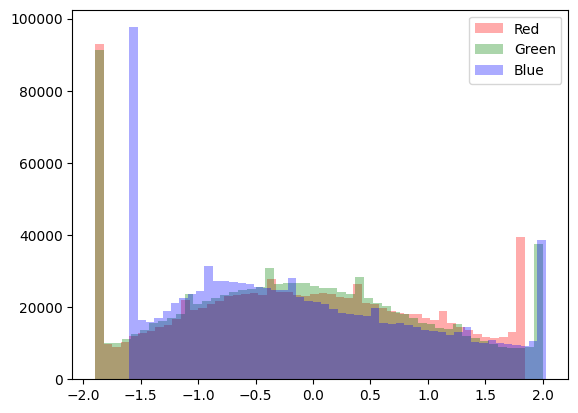

In [7]:
if GET_DATASET_STATS_FLAG:
    # Note: This computes stats on transformed (augmented + normalized) data, which isn't ideal for verifying raw mean/std.
    # If you want raw stats, use a temp dataset without transforms/normalize.
    imgs = []
    for index, item in enumerate(cifar_train_dataset):
        # Sampling 1000 images only
        if index > 1000:
            break
        else:
            imgs.append(item[0])
    # imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [8]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].cpu()
        # Denormalize first (expects C x H x W)
        image_data = denormalize(image_data, mean=CIFAR100_MEAN, std=CIFAR100_STD)
        # Then permute to H x W x C for visualization
        image_data = image_data.permute(1, 2, 0)
        plt.imshow(image_data)
        plt.title(CIFAR100_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

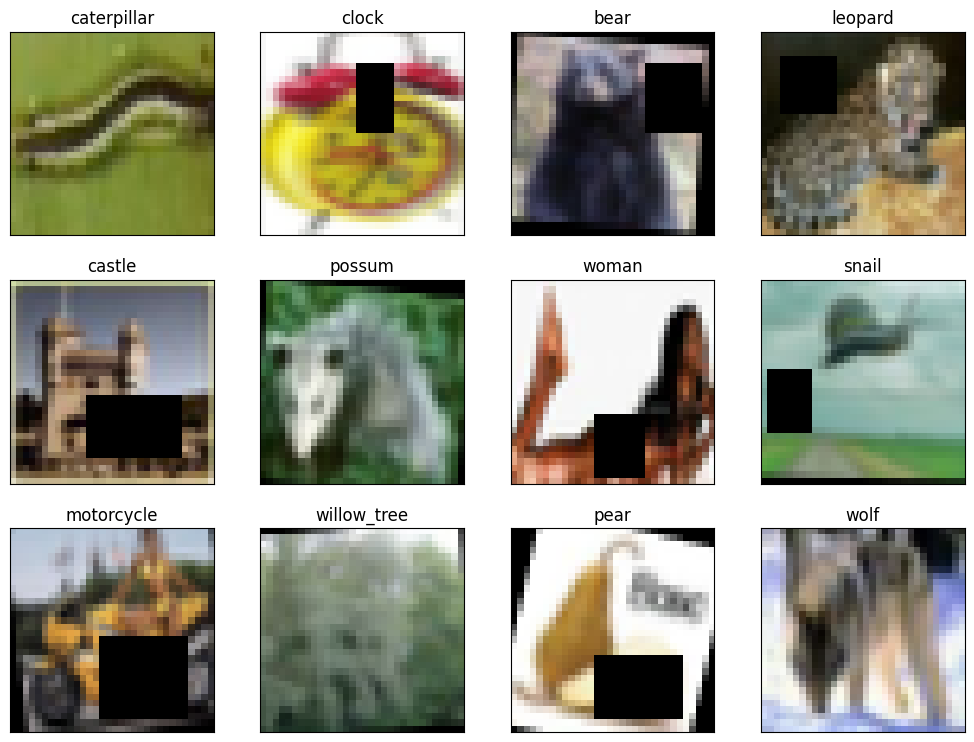

In [9]:
dataset_visualizer(train_loader)

In [10]:
# ============================================================
# 1️⃣ Train/test loops
# ============================================================
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')


def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        save_dir = "/content/drive/MyDrive/CIFAR100" if 'google.colab' in sys.modules else "."
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pt"))
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
print("Output shape:", dummy_output.shape)  # should be [5, 100]
summary(model, input_size=(3, 32, 32), device=str(device))

Output shape: torch.Size([5, 100])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
    

c:\Users\achakravarti\Documents\ERAv4\ERAv4\.venv\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 82%|████████▏ | 82/100 [00:57<00:12,  1.44it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-01


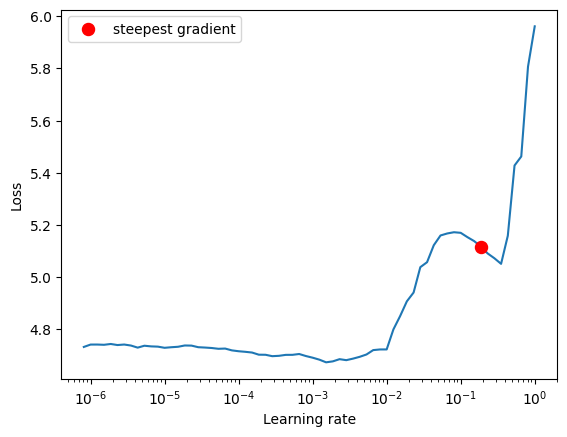

In [12]:
from torch_lr_finder import LRFinder

model = ResNet(layers=[2,2,3,2], num_classes=100, use_depthwise=(False, False, True, True)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [13]:
# ============================================================
# 2️⃣ Checkpoint save/load helpers
# ============================================================

def save_checkpoint(model, optimizer, scheduler, epoch, best_loss, path="checkpoint.pt"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_loss": best_loss,
    }
    torch.save(checkpoint, path)
    print(f"💾 Saved checkpoint (epoch {epoch})")

def load_checkpoint(model, optimizer, scheduler, path="checkpoint.pt", device="cuda"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    print(f"🔁 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint["epoch"] + 1, checkpoint["best_loss"]


In [14]:
# ============================================================
# 3️⃣ Model, optimizer, scheduler setup
# ============================================================

# Example: customize your ResNet to use partial depthwise convs
model = ResNet(layers=[2, 2, 3, 2], num_classes=100,
               use_depthwise=(False, False, True, True)).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# You already ran LR Finder earlier and got:
# Suggested LR ≈ 0.187
max_lr = 0.187    # Use from LR Finder output
total_epochs = 40 # Full plan (even if train 20+20)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=total_epochs,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=25.0,
    final_div_factor=1e4,
)

# ============================================================
# 4️⃣ Resume if checkpoint exists
# ============================================================

start_epoch = 0
if os.path.exists("checkpoint.pt"):
    start_epoch, best_loss = load_checkpoint(model, optimizer, scheduler, "checkpoint.pt", device)
else:
    best_loss = float("inf")

# ============================================================
# 5️⃣ Main training loop
# ============================================================

for epoch in range(start_epoch, total_epochs):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    scheduler.step()                      # OneCycle step per epoch
    save_checkpoint(model, optimizer, scheduler, epoch, best_loss)

loss=3.9495 batch_id=1562: 100%|██████████| 1563/1563 [16:10<00:00,  1.61it/s]



Train set (epoch 0): Average loss: 4.1888, Accuracy: 2529/50000 (5.06%)

Test set (epoch 0): Average loss: 3.7496, Accuracy: 1096/10000 (10.96%)

✅ Saved new best model at epoch 0 with loss 3.7496
💾 Saved checkpoint (epoch 0)


loss=3.5781 batch_id=1562: 100%|██████████| 1563/1563 [18:05<00:00,  1.44it/s]



Train set (epoch 1): Average loss: 3.6647, Accuracy: 6322/50000 (12.64%)

Test set (epoch 1): Average loss: 3.4125, Accuracy: 1731/10000 (17.31%)

✅ Saved new best model at epoch 1 with loss 3.4125
💾 Saved checkpoint (epoch 1)


loss=3.3846 batch_id=731:  47%|████▋     | 732/1563 [11:52<13:28,  1.03it/s]


KeyboardInterrupt: 

In [23]:
for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    reduce_lr.step(test_loss)

loss=0.5696 batch_id=97: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Train set (epoch 0): Average loss: 0.5847, Accuracy: 39806/50000 (79.61%)



Test set (epoch 0): Average loss: 0.5837, Accuracy: 7985/10000 (79.85%)



loss=0.6041 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]


Train set (epoch 1): Average loss: 0.5879, Accuracy: 39636/50000 (79.27%)



Test set (epoch 1): Average loss: 0.5638, Accuracy: 8096/10000 (80.96%)



loss=0.7177 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


Train set (epoch 2): Average loss: 0.5702, Accuracy: 40061/50000 (80.12%)



Test set (epoch 2): Average loss: 0.5476, Accuracy: 8167/10000 (81.67%)



loss=0.6805 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


Train set (epoch 3): Average loss: 0.5639, Accuracy: 40175/50000 (80.35%)



Test set (epoch 3): Average loss: 0.5637, Accuracy: 8142/10000 (81.42%)



loss=0.4775 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Train set (epoch 4): Average loss: 0.5559, Accuracy: 40286/50000 (80.57%)



Test set (epoch 4): Average loss: 0.5264, Accuracy: 8235/10000 (82.35%)

✅ Saved new best model at epoch 4 with loss 0.5264


loss=0.5847 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Train set (epoch 5): Average loss: 0.5513, Accuracy: 40369/50000 (80.74%)



Test set (epoch 5): Average loss: 0.5180, Accuracy: 8219/10000 (82.19%)

✅ Saved new best model at epoch 5 with loss 0.5180


loss=0.5618 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Train set (epoch 6): Average loss: 0.5388, Accuracy: 40606/50000 (81.21%)



Test set (epoch 6): Average loss: 0.5225, Accuracy: 8222/10000 (82.22%)



loss=0.6413 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Train set (epoch 7): Average loss: 0.5291, Accuracy: 40745/50000 (81.49%)



Test set (epoch 7): Average loss: 0.5505, Accuracy: 8122/10000 (81.22%)



loss=0.4868 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Train set (epoch 8): Average loss: 0.5224, Accuracy: 40877/50000 (81.75%)



Test set (epoch 8): Average loss: 0.5585, Accuracy: 8142/10000 (81.42%)



loss=0.5795 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


Train set (epoch 9): Average loss: 0.5185, Accuracy: 41005/50000 (82.01%)



Test set (epoch 9): Average loss: 0.5965, Accuracy: 8019/10000 (80.19%)



loss=0.5530 batch_id=97: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Train set (epoch 10): Average loss: 0.5120, Accuracy: 41109/50000 (82.22%)



Test set (epoch 10): Average loss: 0.5098, Accuracy: 8283/10000 (82.83%)

✅ Saved new best model at epoch 10 with loss 0.5098


loss=0.5837 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]


Train set (epoch 11): Average loss: 0.5049, Accuracy: 41179/50000 (82.36%)



Test set (epoch 11): Average loss: 0.5017, Accuracy: 8341/10000 (83.41%)

✅ Saved new best model at epoch 11 with loss 0.5017


loss=0.5285 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


Train set (epoch 12): Average loss: 0.5029, Accuracy: 41232/50000 (82.46%)



Test set (epoch 12): Average loss: 0.5066, Accuracy: 8311/10000 (83.11%)



loss=0.4916 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]


Train set (epoch 13): Average loss: 0.4972, Accuracy: 41317/50000 (82.63%)



Test set (epoch 13): Average loss: 0.4898, Accuracy: 8341/10000 (83.41%)

✅ Saved new best model at epoch 13 with loss 0.4898


loss=0.5426 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]


Train set (epoch 14): Average loss: 0.4886, Accuracy: 41452/50000 (82.90%)



Test set (epoch 14): Average loss: 0.5221, Accuracy: 8246/10000 (82.46%)



loss=0.4167 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Train set (epoch 15): Average loss: 0.4866, Accuracy: 41561/50000 (83.12%)



Test set (epoch 15): Average loss: 0.5043, Accuracy: 8335/10000 (83.35%)



loss=0.4123 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


Train set (epoch 16): Average loss: 0.4789, Accuracy: 41651/50000 (83.30%)



Test set (epoch 16): Average loss: 0.5319, Accuracy: 8308/10000 (83.08%)



loss=0.5997 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]


Train set (epoch 17): Average loss: 0.4761, Accuracy: 41706/50000 (83.41%)



Test set (epoch 17): Average loss: 0.5031, Accuracy: 8342/10000 (83.42%)



loss=0.4670 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]


Train set (epoch 18): Average loss: 0.4703, Accuracy: 41787/50000 (83.57%)



Test set (epoch 18): Average loss: 0.5174, Accuracy: 8297/10000 (82.97%)



loss=0.4681 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Train set (epoch 19): Average loss: 0.4706, Accuracy: 41764/50000 (83.53%)



Test set (epoch 19): Average loss: 0.5649, Accuracy: 8131/10000 (81.31%)



In [24]:
for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    reduce_lr.step(test_loss)

loss=0.4786 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Train set (epoch 0): Average loss: 0.4662, Accuracy: 41861/50000 (83.72%)



Test set (epoch 0): Average loss: 0.4929, Accuracy: 8346/10000 (83.46%)



loss=0.4998 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]


Train set (epoch 1): Average loss: 0.4574, Accuracy: 42011/50000 (84.02%)



Test set (epoch 1): Average loss: 0.5427, Accuracy: 8160/10000 (81.60%)



loss=0.4901 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Train set (epoch 2): Average loss: 0.4522, Accuracy: 42022/50000 (84.04%)



Test set (epoch 2): Average loss: 0.5254, Accuracy: 8275/10000 (82.75%)



loss=0.5078 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]


Train set (epoch 3): Average loss: 0.4497, Accuracy: 42141/50000 (84.28%)



Test set (epoch 3): Average loss: 0.5009, Accuracy: 8343/10000 (83.43%)



loss=0.3861 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]


Train set (epoch 4): Average loss: 0.4449, Accuracy: 42159/50000 (84.32%)



Test set (epoch 4): Average loss: 0.4824, Accuracy: 8403/10000 (84.03%)

✅ Saved new best model at epoch 4 with loss 0.4824


loss=0.4255 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Train set (epoch 5): Average loss: 0.4326, Accuracy: 42491/50000 (84.98%)



Test set (epoch 5): Average loss: 0.4741, Accuracy: 8414/10000 (84.14%)

✅ Saved new best model at epoch 5 with loss 0.4741


loss=0.4470 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Train set (epoch 6): Average loss: 0.4374, Accuracy: 42366/50000 (84.73%)



Test set (epoch 6): Average loss: 0.4762, Accuracy: 8417/10000 (84.17%)



loss=0.3850 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]


Train set (epoch 7): Average loss: 0.4383, Accuracy: 42336/50000 (84.67%)



Test set (epoch 7): Average loss: 0.4826, Accuracy: 8403/10000 (84.03%)



loss=0.3967 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Train set (epoch 8): Average loss: 0.4368, Accuracy: 42283/50000 (84.57%)



Test set (epoch 8): Average loss: 0.4828, Accuracy: 8447/10000 (84.47%)



loss=0.4865 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]


Train set (epoch 9): Average loss: 0.4294, Accuracy: 42446/50000 (84.89%)



Test set (epoch 9): Average loss: 0.5093, Accuracy: 8368/10000 (83.68%)



loss=0.4022 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]


Train set (epoch 10): Average loss: 0.4200, Accuracy: 42696/50000 (85.39%)



Test set (epoch 10): Average loss: 0.4462, Accuracy: 8507/10000 (85.07%)

✅ Saved new best model at epoch 10 with loss 0.4462


loss=0.5128 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Train set (epoch 11): Average loss: 0.4221, Accuracy: 42688/50000 (85.38%)



Test set (epoch 11): Average loss: 0.4847, Accuracy: 8430/10000 (84.30%)



loss=0.4154 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Train set (epoch 12): Average loss: 0.4166, Accuracy: 42738/50000 (85.48%)



Test set (epoch 12): Average loss: 0.5236, Accuracy: 8299/10000 (82.99%)



loss=0.4289 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Train set (epoch 13): Average loss: 0.4200, Accuracy: 42626/50000 (85.25%)



Test set (epoch 13): Average loss: 0.4545, Accuracy: 8529/10000 (85.29%)



loss=0.4195 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Train set (epoch 14): Average loss: 0.4127, Accuracy: 42669/50000 (85.34%)



Test set (epoch 14): Average loss: 0.5054, Accuracy: 8335/10000 (83.35%)



loss=0.4498 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]


Train set (epoch 15): Average loss: 0.4136, Accuracy: 42738/50000 (85.48%)



Test set (epoch 15): Average loss: 0.5041, Accuracy: 8336/10000 (83.36%)



loss=0.4493 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]


Train set (epoch 16): Average loss: 0.4045, Accuracy: 42933/50000 (85.87%)



Test set (epoch 16): Average loss: 0.4887, Accuracy: 8450/10000 (84.50%)



loss=0.4353 batch_id=97: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Train set (epoch 17): Average loss: 0.4036, Accuracy: 42962/50000 (85.92%)



Test set (epoch 17): Average loss: 0.4672, Accuracy: 8453/10000 (84.53%)



loss=0.3680 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]


Train set (epoch 18): Average loss: 0.4051, Accuracy: 42841/50000 (85.68%)



Test set (epoch 18): Average loss: 0.4935, Accuracy: 8430/10000 (84.30%)



loss=0.3911 batch_id=97: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]


Train set (epoch 19): Average loss: 0.3944, Accuracy: 43100/50000 (86.20%)



Test set (epoch 19): Average loss: 0.4612, Accuracy: 8471/10000 (84.71%)



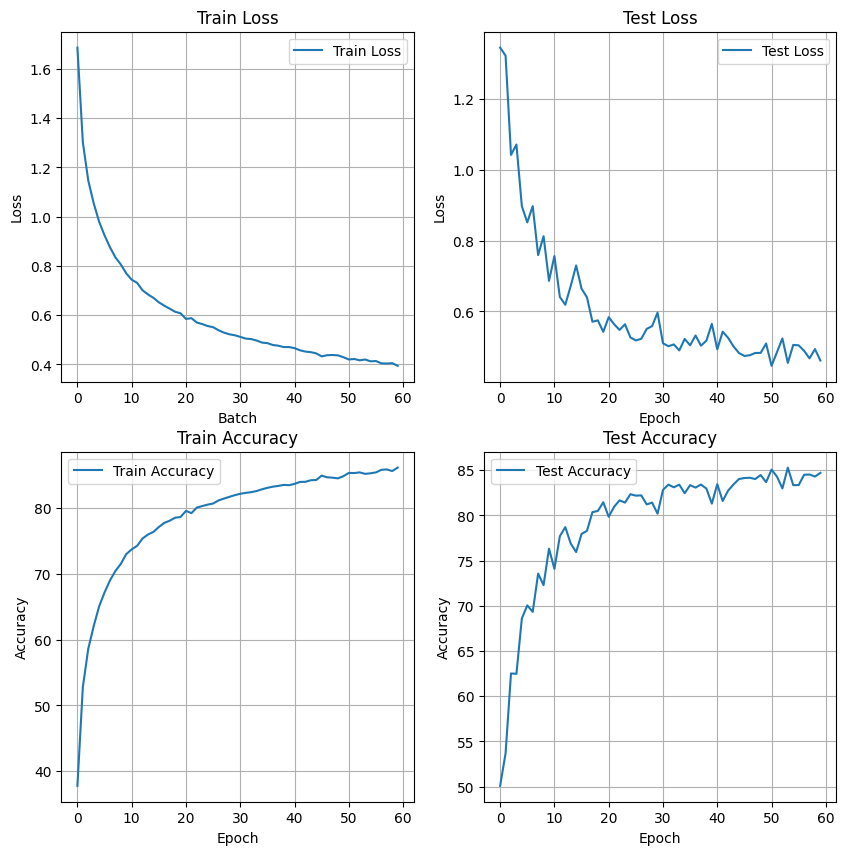

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()